In [139]:
# conda activate chronocell

import os
import sys
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath("code"))
from protein_from_RNA import *

# sys.path.append("/mnt/lareaulab/reliscu/programs/FGP_2024")
# import Chronocell
# from Chronocell.inference import Trajectory
# from Chronocell.mixtures import PoissonMixtureSS
# from Chronocell.utils import *
# from Chronocell.plotting import *
# from Chronocell.models.two_species_ss import get_Y

In [140]:
random_seed = 0

In [ ]:
# Splicing rate
beta_mu = 2
beta_sd = 0.5

# Transcription rate
alpha_mu = np.log(2) # 2
alpha_sd = 1

# Translation rate
transl_rate_mu = np.log(100)
transl_rate_sd = 1

# mRNA degradation rate
rna_median_half_life = 9
gamma_rate = np.log(2) / rna_median_half_life
gamma_mu = np.log(gamma_rate) # Median of lognormal
gamma_sd = 0.5

# Protein degradation rate
protein_median_half_life = 46
deg_rate = np.log(2) / protein_median_half_life
deg_rate_mu = np.log(deg_rate) # Median of lognormal
deg_rate_sd = 1.5

# # # Read depth
# rd_mu = 0.25
# rd_var = 1/64

In [142]:
# Simulate data

n = 1000 # No. cells per lineage
p = 1000 # No. genes
topo = np.array([[0, 1, 2], [0, 1, 3]])
tau = (0, 6, 12)

theta = get_RNA_params(topo, p, alpha_mu, alpha_sd, beta_mu, beta_sd, gamma_mu, gamma_sd, random_seed=random_seed)
phi = get_protein_params(p, transl_rate_mu, transl_rate_sd, deg_rate_mu, deg_rate_sd, random_seed=random_seed)
Y_observed, Y, theta, rd, true_t, true_l = simulate_RNA(topo, tau, theta, n, random_seed=random_seed)
P_observed, P = simulate_protein_from_RNA(Y_observed, topo, true_t, true_l, phi, random_seed=random_seed)

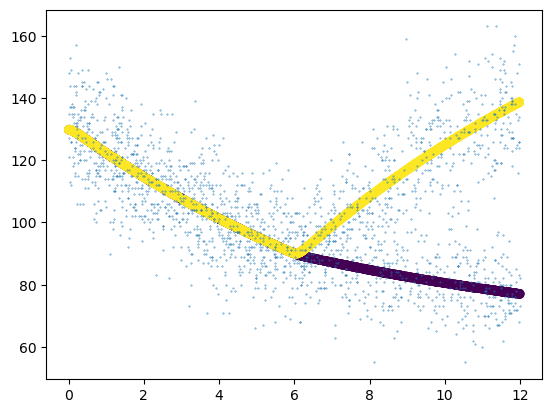

In [200]:
idx = 0
plt.scatter(true_t, Y[:, idx, 1], c=true_l)
plt.scatter(true_t, Y_observed[:, idx, 1], s=.1)

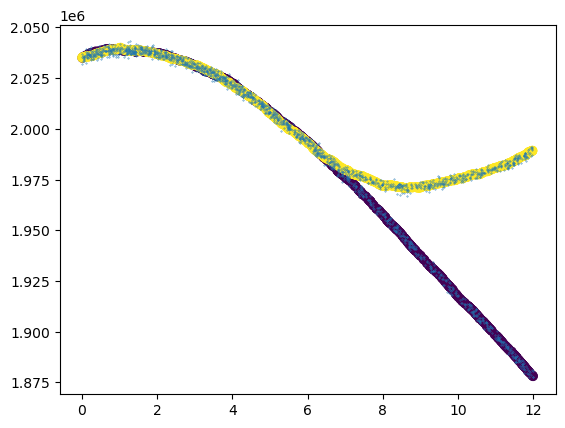

In [201]:
plt.scatter(true_t, P[:,idx], c=true_l)
plt.scatter(true_t, P_observed[:,idx], s=.1)

In [148]:
# PCA RNA counts and color by time
# Is there a ground truth of what that should look like

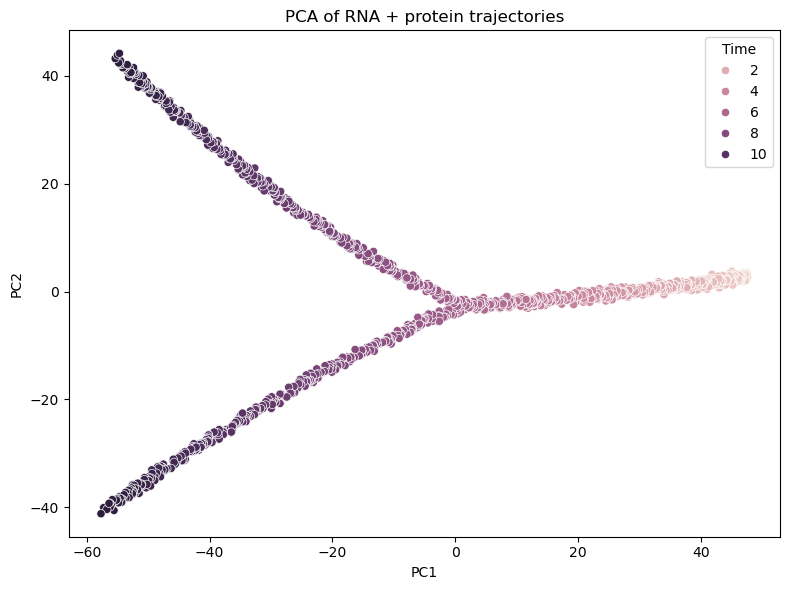

In [ ]:
# PCA on cells 

import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

l = 0

Y_norm = stats.zscore(Y_observed[:,:,1])
P_norm = stats.zscore(P_observed)

# === Step 2: Concatenate RNA and protein for PCA ===
combined_traj = np.concatenate([Y_norm, P_norm], axis=1)
pca = PCA(n_components=10)
traj_pca = pca.fit_transform(combined_traj)

# === Step 3: Clustering ===
meta = pd.DataFrame()
meta['PC1'] = traj_pca[:,0]
meta['PC2'] = traj_pca[:,1]
meta['Time'] = true_t

# === Step 4: Visualization ===
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=meta, hue='Time')
plt.title('PCA of RNA + protein trajectories')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

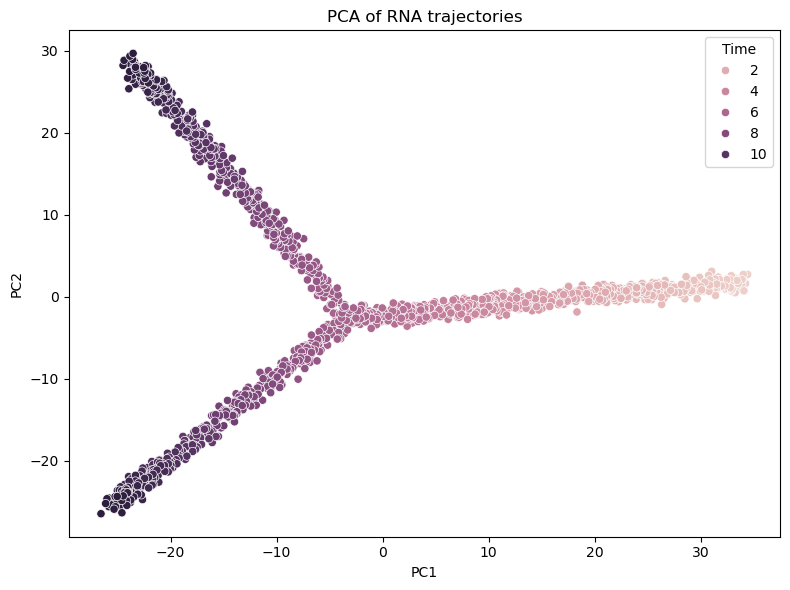

In [ ]:
# === Step 2: Concatenate RNA and protein for PCA ===
combined_traj = Y_norm
pca = PCA(n_components=10)
traj_pca = pca.fit_transform(combined_traj)

# === Step 3: Clustering ===
meta = pd.DataFrame()
meta['PC1'] = traj_pca[:,0]
meta['PC2'] = traj_pca[:,1]
meta['Time'] = true_t

# === Step 4: Visualization ===
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=meta, hue='Time')
plt.title('PCA of RNA trajectories')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

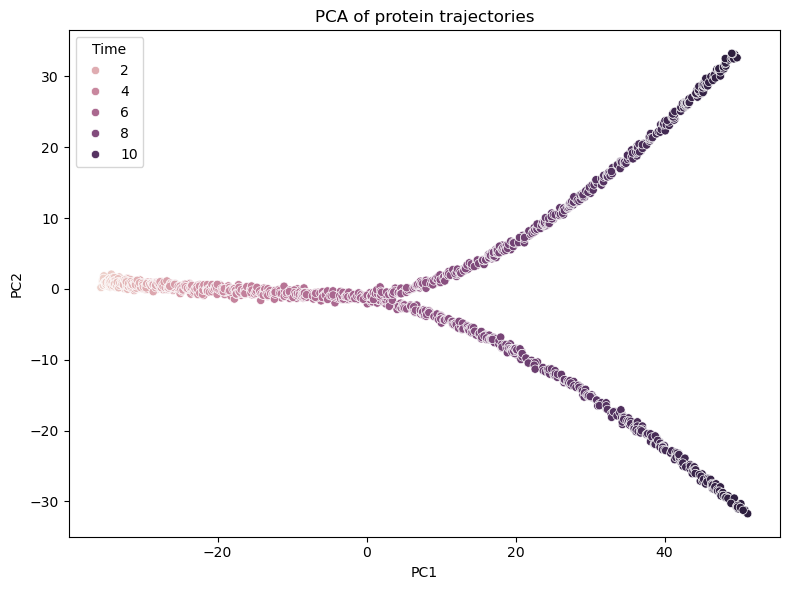

In [ ]:
# === Step 2: Concatenate RNA and protein for PCA ===
combined_traj = P_norm
pca = PCA(n_components=10)
traj_pca = pca.fit_transform(combined_traj)

# === Step 3: Clustering ===
meta = pd.DataFrame()
meta['PC1'] = traj_pca[:,0]
meta['PC2'] = traj_pca[:,1]
meta['Time'] = true_t

# === Step 4: Visualization ===
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=meta, hue='Time')
plt.title('PCA of protein trajectories')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

In [ ]:
# l = 0

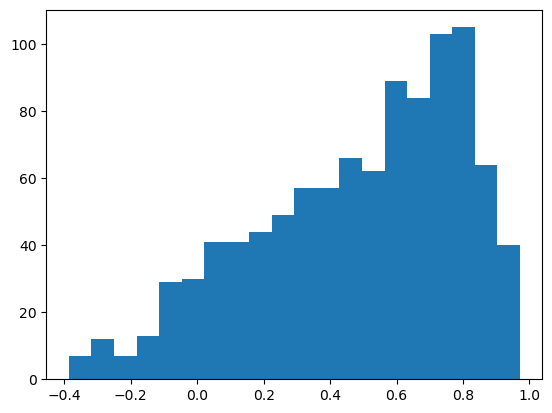

In [268]:
# theta_l = np.concatenate((theta[:,topo[l]], theta[:,-2:]), axis=1)

rows = []
for i in range(p):
    y_i = Y_observed[:, i, 1]
    p_i = P_observed[:,i]
   
    steady_state = theta[i, 0]
    alpha_vals = theta[i, 1:-2]  # all columns after steady_state up to beta
    beta = theta[i, -2]
    gamma = theta[i, -1]
     
    row = {
        'Cor': np.corrcoef(y_i, p_i)[0, 1],
        'Steady_state': steady_state,
        'Beta': beta,
        'Gamma': gamma,
        'Translation_rate': phi[i, 0],
        'Degradation_rate': phi[i, -1]
    }
    
    for j, val in enumerate(alpha_vals, 1):
        row[f'Alpha {j}'] = val
    
    rows.append(row)

data = pd.DataFrame(rows)

param_cols = data.columns.values[1:data.shape[0]]

plt.hist(data['Cor'], bins=20);

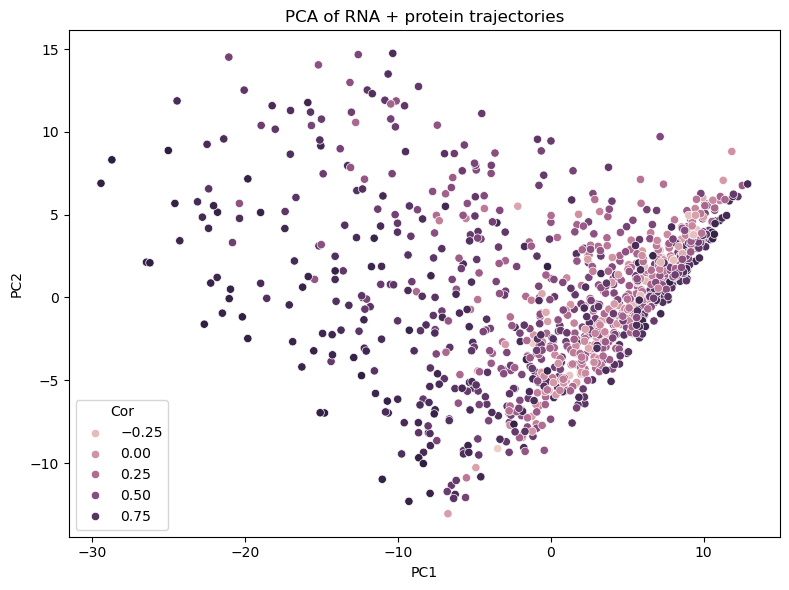

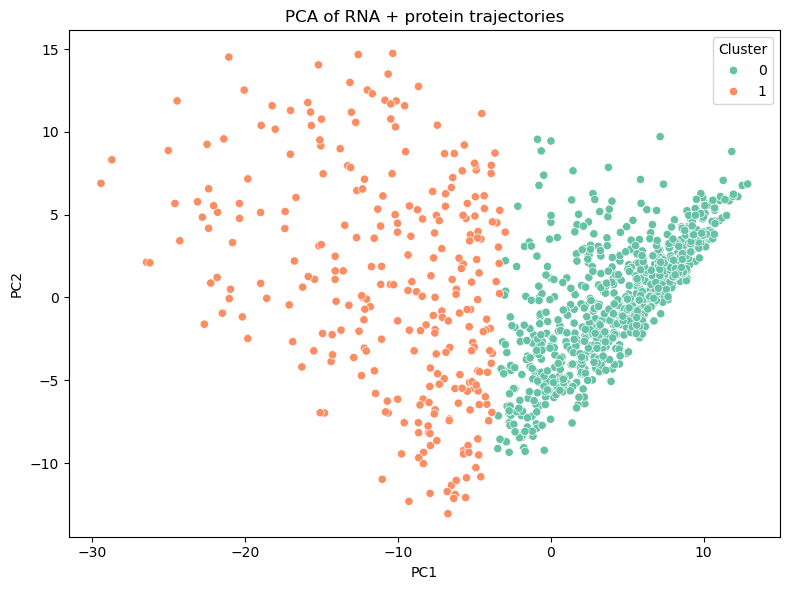

              Cor  Steady_state      Beta     Gamma  Translation_rate  \
Cluster                                                                 
0        0.399190      0.563347  8.637296  0.080375        152.465194   
1        0.696899      0.163766  8.077825  0.100903        163.675360   

         Degradation_rate   Alpha 1   Alpha 2   Alpha 3        PC1       PC2  
Cluster                                                                       
0                0.031893  0.436173  0.377650  0.415415   4.067057 -0.332317  
1                0.075710  0.541806  0.745408  0.693844 -10.458146  0.854531  


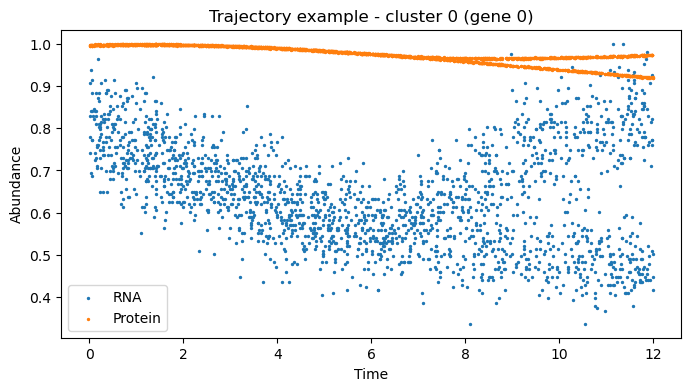

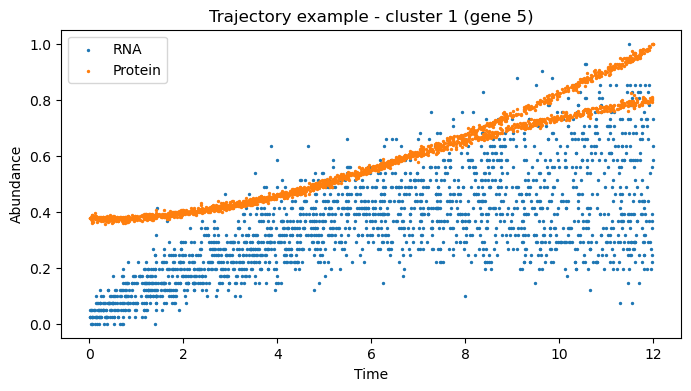

In [271]:
# PCA on genes 

import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

Y_norm = Y_observed[:,:,1] / np.max(Y_observed[:,:,1], axis=0)
P_norm = P_observed / np.max(P_observed, axis=0)

# === Step 2: Concatenate RNA and protein for PCA ===
combined_traj = np.concatenate([Y_norm, P_norm], axis=0)
pca = PCA(n_components=3)
traj_pca = pca.fit_transform(combined_traj.T)

# === Step 3: Clustering ===
kmeans = KMeans(n_clusters=2, random_state=0)
data['Cluster'] = kmeans.fit_predict(traj_pca)
data['PC1'] = traj_pca[:,0]
data['PC2'] = traj_pca[:,1]

# === Step 4: Visualization ===
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=data, hue='Cor')
plt.title('PCA of RNA + protein trajectories')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=data, hue='Cluster', palette='Set2')
plt.title('PCA of RNA + protein trajectories')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

# === Step 5: Correlation Summary by Cluster ===
print(data.groupby('Cluster').mean().sort_values('Cor'))

# Plot representative gene trajectories from each cluster
for c in sorted(data['Cluster'].unique()):
    idx = data[data['Cluster'] == c].index[0]  # random gene in cluster
    plt.figure(figsize=(8, 4))
    plt.scatter(true_t, Y_norm[:,idx], label='RNA', s=2)
    plt.scatter(true_t, P_norm[:,idx], label='Protein', s=2)
    plt.title(f'Trajectory example - cluster {c} (gene {idx})')
    plt.xlabel('Time')
    plt.ylabel('Abundance')
    plt.legend()
    plt.show()

Mean Squared Error: 0.03851419433042233
R-squared: 0.5781548451167178


<Axes: >

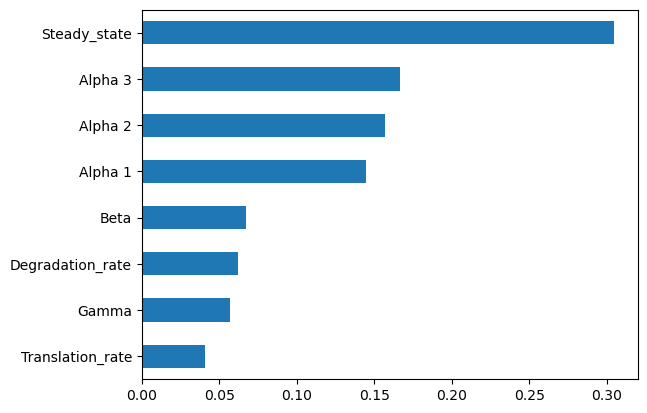

In [272]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Separate features and target
X = data[param_cols]
y = data['Cor']

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

importances = pd.Series(model.feature_importances_, index=param_cols)
importances.sort_values(ascending=True).plot(kind='barh')

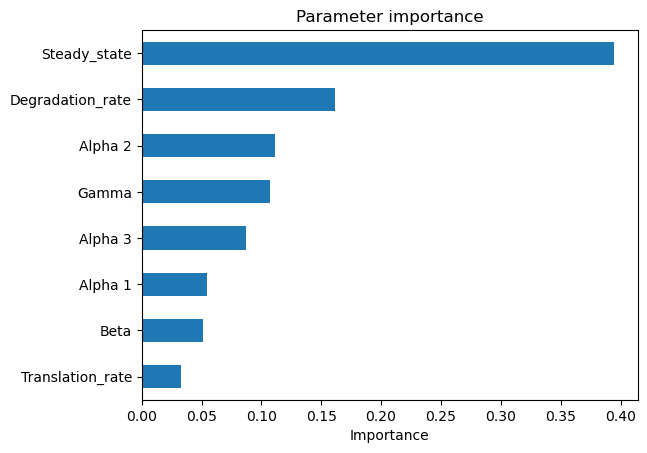

In [273]:
from sklearn.ensemble import RandomForestClassifier

X_params = data[param_cols]
y_clusters = data['Cluster']

clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(X_params, y_clusters)

importances = pd.Series(clf.feature_importances_, index=param_cols)
importances.sort_values(ascending=True).plot(kind='barh')
plt.title("Parameter importance")
plt.xlabel("Importance")
plt.show()

In [ ]:
sns.pairplot(data, vars=param_cols, hue='Cor', palette='viridis')

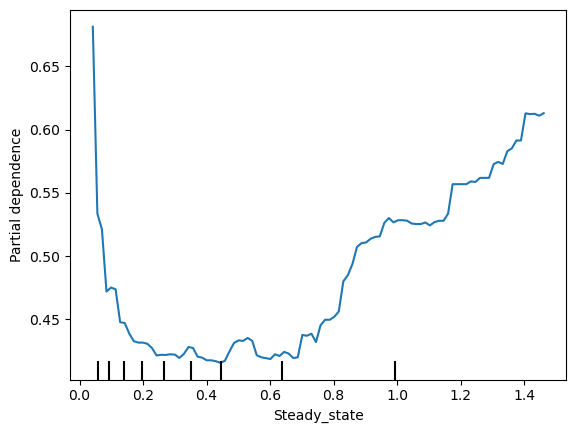

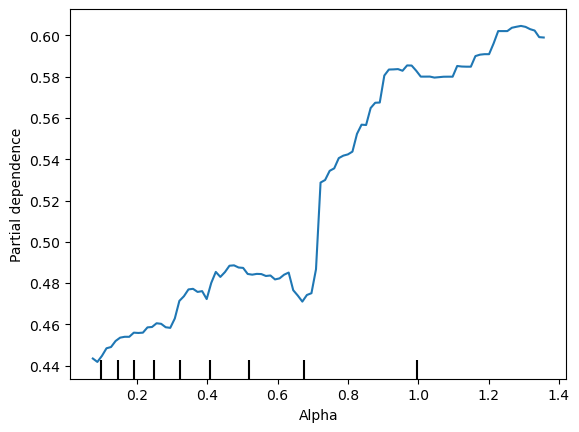

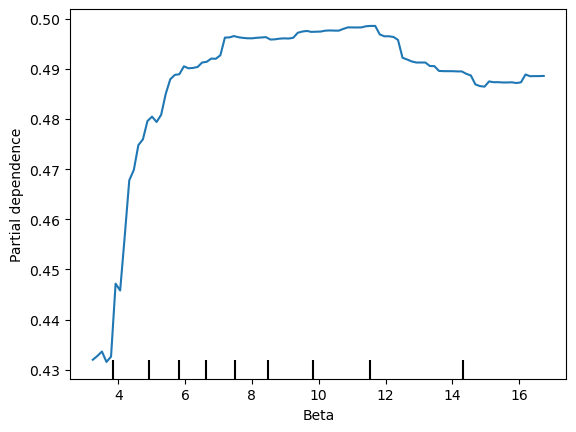

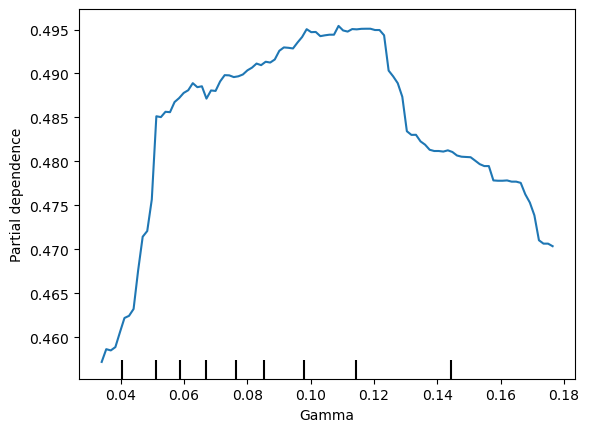

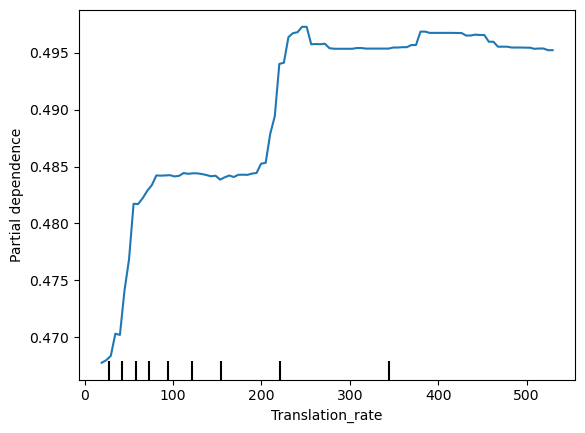

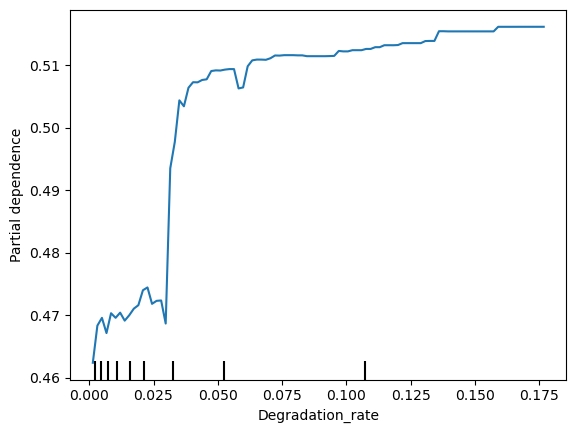

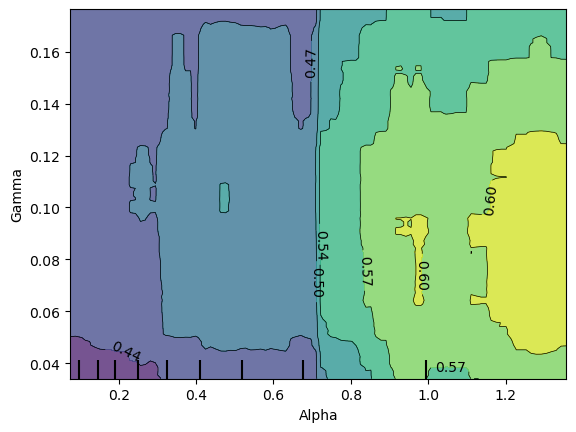

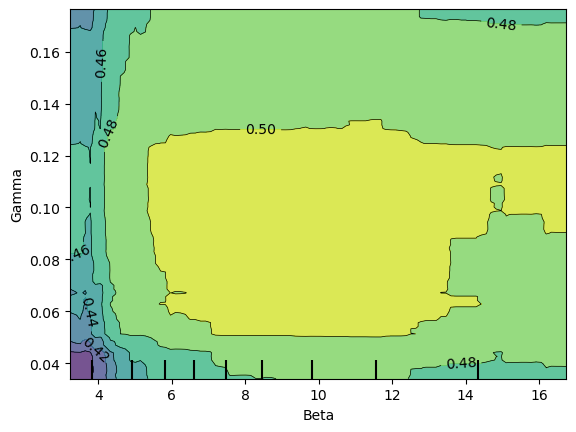

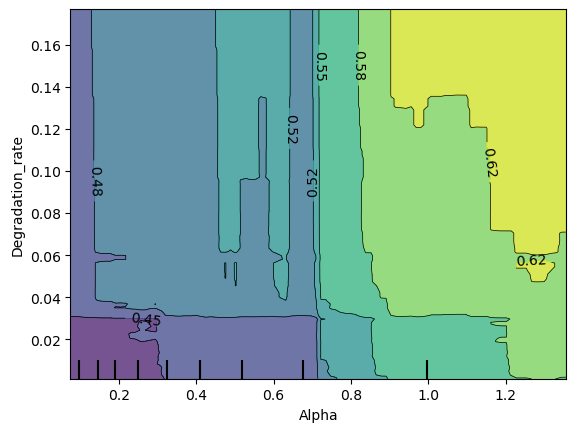

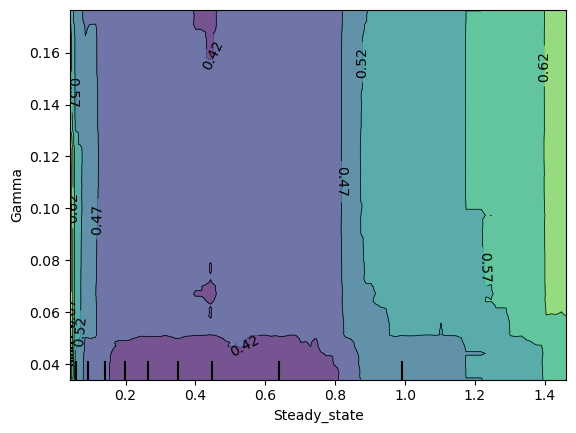

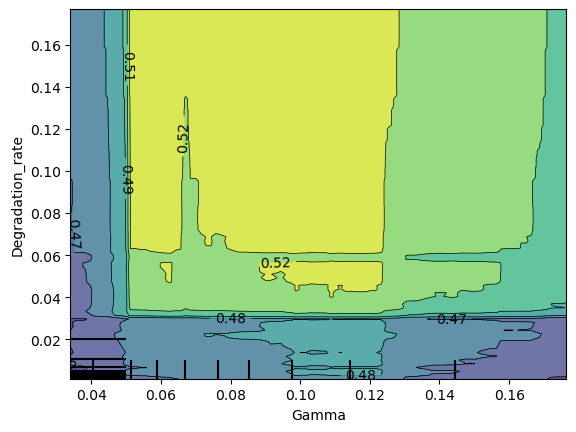

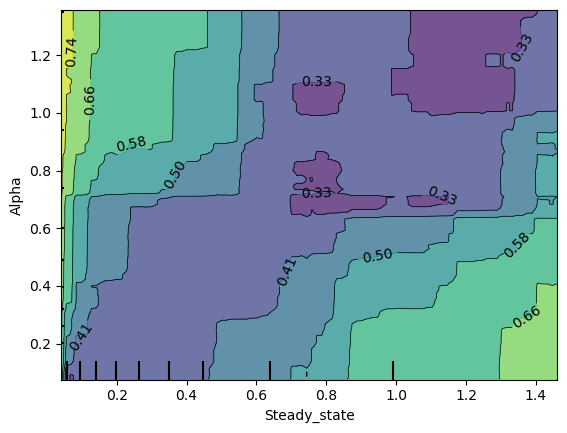

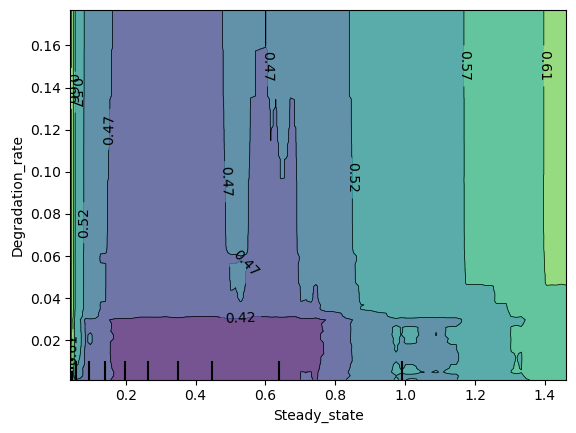

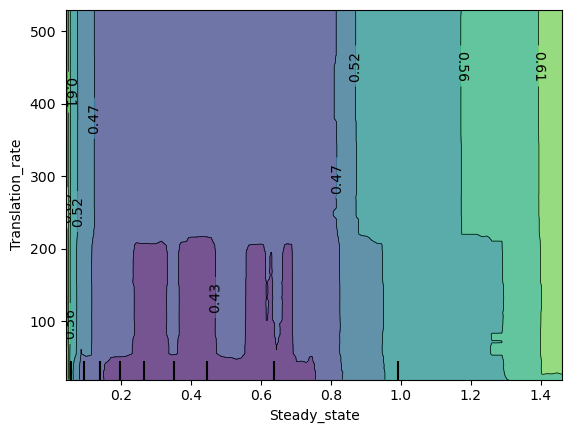

In [233]:
from sklearn.inspection import PartialDependenceDisplay

X = data[param_cols]
y = data['Cor']

model = RandomForestRegressor(n_estimators=100, max_depth=len(param_cols), random_state=0)
model.fit(X, y)

# PDP plots

PartialDependenceDisplay.from_estimator(model, X, features=['Steady_state'])
PartialDependenceDisplay.from_estimator(model, X, features=['Alpha'])
PartialDependenceDisplay.from_estimator(model, X, features=['Beta'])
PartialDependenceDisplay.from_estimator(model, X, features=['Gamma'])
PartialDependenceDisplay.from_estimator(model, X, features=['Translation_rate'])
PartialDependenceDisplay.from_estimator(model, X, features=['Degradation_rate'])

PartialDependenceDisplay.from_estimator(model, X, features=[('Alpha', 'Gamma')])
PartialDependenceDisplay.from_estimator(model, X, features=[('Beta', 'Gamma')])
PartialDependenceDisplay.from_estimator(model, X, features=[('Alpha', 'Degradation_rate')])
PartialDependenceDisplay.from_estimator(model, X, features=[('Steady_state', 'Gamma')])
PartialDependenceDisplay.from_estimator(model, X, features=[('Gamma', 'Degradation_rate')])
PartialDependenceDisplay.from_estimator(model, X, features=[('Steady_state', 'Alpha')])
PartialDependenceDisplay.from_estimator(model, X, features=[('Steady_state', 'Degradation_rate')])
PartialDependenceDisplay.from_estimator(model, X, features=[('Steady_state', 'Translation_rate')])

In [238]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

# Generate polynomial interaction features
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Fit linear regression on polynomial features
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Get interaction term names
feature_names = poly.get_feature_names_out(X.columns)  # X must be a DataFrame
coeffs = pd.Series(model.coef_, index=feature_names).sort_values(key=abs, ascending=False)
print(coeffs.head(15))

# Make predictions
y_pred = model.predict(X_test_poly)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Gamma                            1.097891
Gamma Degradation_rate          -0.938460
Alpha Gamma                     -0.722582
Steady_state                     0.289657
Steady_state Alpha              -0.239357
Steady_state Degradation_rate    0.224944
Alpha                            0.203478
Degradation_rate                -0.131285
Beta Gamma                      -0.102500
Alpha Degradation_rate          -0.092625
Beta Degradation_rate            0.075380
Steady_state Gamma              -0.072512
Beta                             0.013088
Alpha Beta                       0.012687
Gamma Translation_rate           0.001451
dtype: float64
Mean Squared Error: 0.0796335743086111
R-squared: 0.12777514700365145


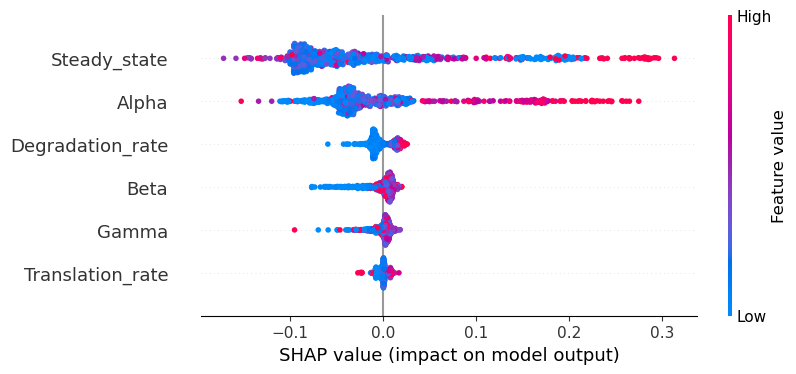

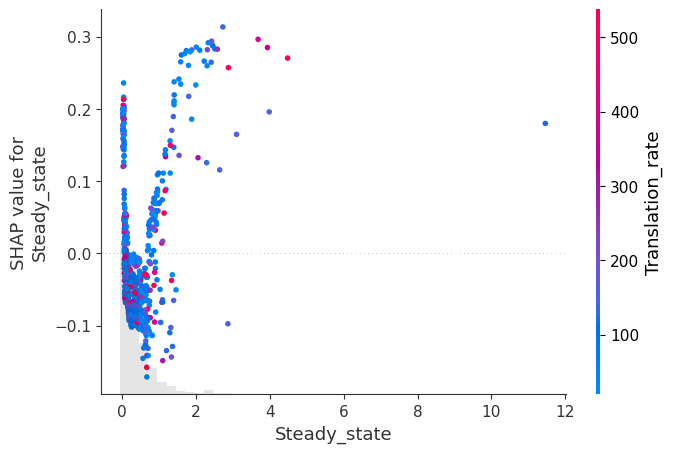

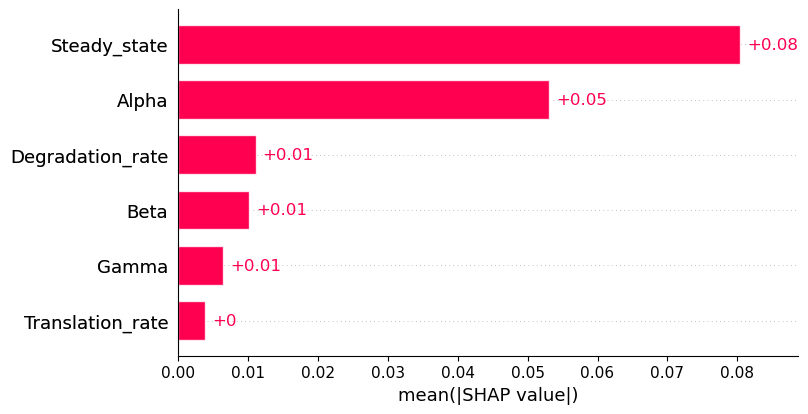

In [242]:
import pandas as pd
import shap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# 1. Prepare features and target
X = data[param_cols]
y = data['Cor']

# 2. Train/test split (optional but recommended for evaluation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 3. Fit Random Forest
model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=0)
model.fit(X_train, y_train)

# 4. Create SHAP explainer with new API
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)  # Explanation object

# 5. Plot summary (beeswarm)
shap.plots.beeswarm(shap_values, max_display=10)

# 6. Plot dependence (e.g. Gamma vs Cor, colored by Translation_rate)
shap.plots.scatter(shap_values[:, "Steady_state"], color=shap_values[:, "Translation_rate"])

# 7. If you want bar plot of mean |SHAP| values:
shap.plots.bar(shap_values, max_display=10)
